# Implementing various MLP Architectures using Keras.

In [1]:
import tensorflow as tf

In [2]:
# checking if the gpu is connected or not

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9299138210179744872
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4840685568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2320203755516720165
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error-- which we will be calling in the later part of the code.
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid() 
    fig.canvas.draw()

In [5]:
# the data, shuffled and split between train and test sets 
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d, %d)"%(X_train.shape[1], X_train.shape[2]))
print("Number of test examples :", X_test.shape[0], "and each image is of shape (%d, %d)"%(X_test.shape[1], X_test.shape[2]))

Number of training examples : 60000 and each image is of shape (28, 28)
Number of test examples : 10000 and each image is of shape (28, 28)


### Now we can see that our input is in the form of a 2-D vector hence we will convert it into a 1-d vector right now that is from 28*28 --->  1 * 784.

In [7]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) 

### After conversion

In [8]:
print("Number of training examples :", X_train.shape[0], "and each image is of shape (%d)"%(X_train.shape[1]))
print("Number of training examples :", X_test.shape[0], "and each image is of shape (%d)"%(X_test.shape[1]))

Number of training examples : 60000 and each image is of shape (784)
Number of training examples : 10000 and each image is of shape (784)


In [9]:
# sample data point
X_train[5]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  13,
        25, 100, 122,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

### Each cell in the above matrix has value between 0 to 255 but as we will be using these cell values for our ML tasks hence lets normalize these values and bring them between 0 and 1

In [10]:
# X => (X - Xmin)/(Xmax-Xmin) = X/255   --- >> note that Xmin = 0

X_train = X_train/255
X_test = X_test/255

In [11]:
#normalized sample data point
X_train[5]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### Now let us check the class labels.

In [12]:
# given label
y_train[5]

2

### Each class label will be a number between 0 to 9 hence let us convert them into vector form using one hot encoding ---> ex: consider an image is 5 convert it into 5 => [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] We are doing so because we will be using the categorical cross entropy loss for our model 

In [13]:
Y_train = np_utils.to_categorical(y_train, 10) 
Y_test = np_utils.to_categorical(y_test, 10)

In [14]:
#label after one hot encoding
Y_train[5]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [15]:
len(Y_train[5])

10

### Using Keras to build our Sequential Model

In [16]:
from keras.models import Sequential 
from keras.layers import Dense, Activation

In [17]:
X_train.shape[1]

784

In [18]:
# some model parameters

output_dim = 10 # as our output will be any number from 0 to 9
input_dim = X_train.shape[1]

batch_size = 128 
nb_epoch = 20

### The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference)needs to receive information about its input shape.you can use input_shape and input_dim to pass the shape of input.

# Start building the model

# Model-1 Type -> Models with Relu activation + Adam optimizer + Dropouts + Batch Normalization

## Model - 1 --> 2 Hidden Layers 

### Model Architecture -->  [(input)--(hidden layer 1 (512 neurons))---(hidden layer 2 (128 neurons))---(output layer)]

In [31]:
# Multilayer perceptron

# https://intoli.com/blog/neural-network-initialization/ 
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(ni+ni+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(ni+ni+1) = 0.055  => N(0,σ) = N(0,0.055)
# h1 =>  σ=√(2/(ni+ni+1) = 0.120  => N(0,σ) = N(0,0.120)

In [25]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout

In [48]:


model_final = Sequential()

model_final.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total para

In [49]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 51us/step - loss: 0.4832 - acc: 0.8522 - val_loss: 0.1638 - val_acc: 0.9504
Epoch 2/20
60000/60000 [==============================] - 2s 40us/step - loss: 0.2508 - acc: 0.9243 - val_loss: 0.1246 - val_acc: 0.9612
Epoch 3/20
60000/60000 [==============================] - 2s 40us/step - loss: 0.1981 - acc: 0.9406 - val_loss: 0.1068 - val_acc: 0.9675
Epoch 4/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.1788 - acc: 0.9466 - val_loss: 0.0953 - val_acc: 0.9707
Epoch 5/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.1536 - acc: 0.9532 - val_loss: 0.0893 - val_acc: 0.9720
Epoch 6/20
60000/60000 [==============================] - 2s 40us/step - loss: 0.1432 - acc: 0.9565 - val_loss: 0.0788 - val_acc: 0.9767
Epoch 7/20
60000/60000 [==============================] - 2s 40us/step - loss: 0.1322 - acc: 0.9591 - val_loss: 0.0802 - val_acc

Test score: 0.06209656530671637
Test accuracy: 0.9825


<IPython.core.display.Javascript object>


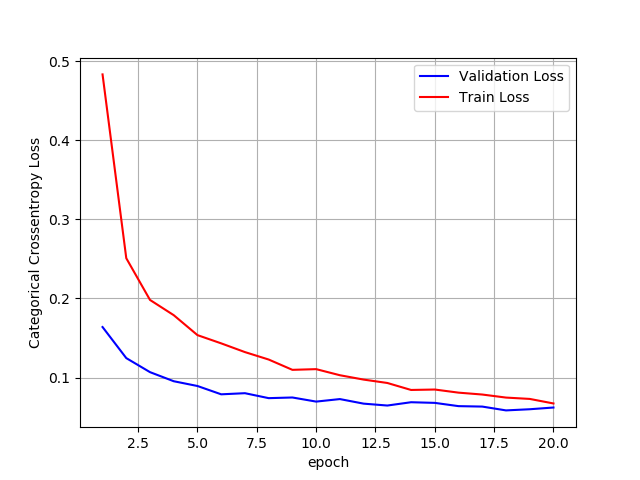

In [50]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Let's give a look at the weights which lead to this accuracy of our model.

<IPython.core.display.Javascript object>


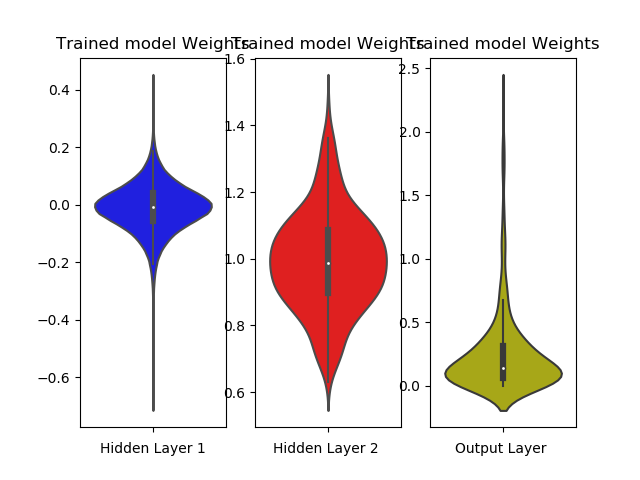

In [51]:
w_after = model_final.get_weights()

h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
out_w = w_after[4].flatten().reshape(-1,1)


fig = plt.figure()
plt.title("Weight matrices after model trained")
plt.subplot(1, 3, 1)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Trained model Weights")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Trained model Weights")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

## Model - 1 --> 3 Hidden Layers

### Model Architecture -->  [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2 (128 neurons))---(hidden layer 3 (256 neurons))---(output layer)]

In [52]:
model_final = Sequential()

model_final.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(256, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
__________

In [53]:
batch_size = 128 
nb_epoch = 40

In [54]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 4s 69us/step - loss: 0.7553 - acc: 0.7651 - val_loss: 0.2128 - val_acc: 0.9367
Epoch 2/40
60000/60000 [==============================] - 3s 52us/step - loss: 0.3450 - acc: 0.8973 - val_loss: 0.1563 - val_acc: 0.9502
Epoch 3/40
60000/60000 [==============================] - 3s 54us/step - loss: 0.2711 - acc: 0.9201 - val_loss: 0.1286 - val_acc: 0.9595
Epoch 4/40
60000/60000 [==============================] - 3s 52us/step - loss: 0.2319 - acc: 0.9310 - val_loss: 0.1067 - val_acc: 0.9671
Epoch 5/40
60000/60000 [==============================] - 3s 51us/step - loss: 0.2034 - acc: 0.9406 - val_loss: 0.1019 - val_acc: 0.9674
Epoch 6/40
60000/60000 [==============================] - 3s 51us/step - loss: 0.1789 - acc: 0.9473 - val_loss: 0.1002 - val_acc: 0.9708
Epoch 7/40
60000/60000 [==============================] - 3s 51us/step - loss: 0.1682 - acc: 0.9505 - val_loss: 0.0938 - val_acc

Test score: 0.06454481310489937
Test accuracy: 0.9833


<IPython.core.display.Javascript object>


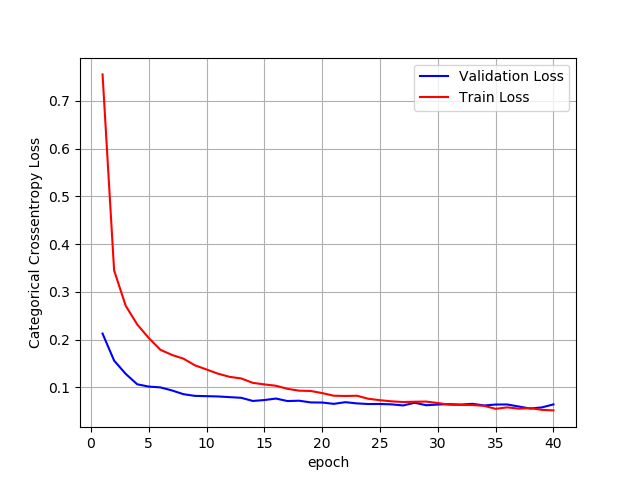

In [55]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Let's give a look at the weights which lead to this accuracy of our model.

<IPython.core.display.Javascript object>


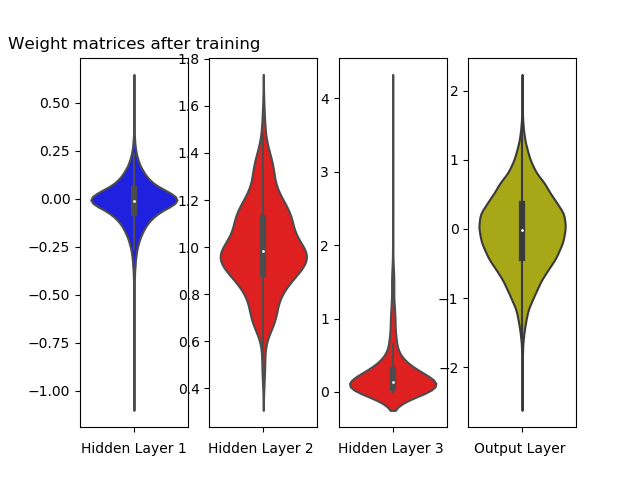

In [56]:
w_after = model_final.get_weights()

h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
h3_w = w_after[4].flatten().reshape(-1,1)
out_w = w_after[6].flatten().reshape(-1,1)


fig = plt.figure()

plt.subplot(1, 4, 1)
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.title("Weight matrices after training")
plt.subplot(1, 4, 2)
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 4, 3)
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('Hidden Layer 3 ')

plt.subplot(1, 4, 4)
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')

plt.show()

## Model - 1 --> 5 Hidden Layers

### Model Architecture -->  [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2 (128 neurons))---(hidden layer 3 (256 neurons))--(hidden layer 4 (1024 neurons))----(hidden layer 5 (2048 neurons))---(output layer)]

In [57]:
model_final = Sequential()

model_final.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(256, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(1024, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(2048, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())
model_final.add(Dropout(0.5))

model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               33024     
__________

In [58]:
batch_size = 256 
nb_epoch = 60

In [59]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 5s 76us/step - loss: 1.3446 - acc: 0.5888 - val_loss: 0.4966 - val_acc: 0.8424
Epoch 2/60
60000/60000 [==============================] - 3s 48us/step - loss: 0.5576 - acc: 0.8277 - val_loss: 0.2985 - val_acc: 0.9067
Epoch 3/60
60000/60000 [==============================] - 3s 47us/step - loss: 0.4277 - acc: 0.8710 - val_loss: 0.2539 - val_acc: 0.9254
Epoch 4/60
60000/60000 [==============================] - 3s 47us/step - loss: 0.3590 - acc: 0.8942 - val_loss: 0.2306 - val_acc: 0.9334
Epoch 5/60
60000/60000 [==============================] - 3s 47us/step - loss: 0.3114 - acc: 0.9078 - val_loss: 0.1989 - val_acc: 0.9455
Epoch 6/60
60000/60000 [==============================] - 3s 49us/step - loss: 0.2770 - acc: 0.9191 - val_loss: 0.1746 - val_acc: 0.9520
Epoch 7/60
60000/60000 [==============================] - 3s 47us/step - loss: 0.2518 - acc: 0.9277 - val_loss: 0.1642 - val_acc

60000/60000 [==============================] - 3s 48us/step - loss: 0.0502 - acc: 0.9852 - val_loss: 0.0763 - val_acc: 0.9841


Test score: 0.07631430160264717
Test accuracy: 0.9841


<IPython.core.display.Javascript object>


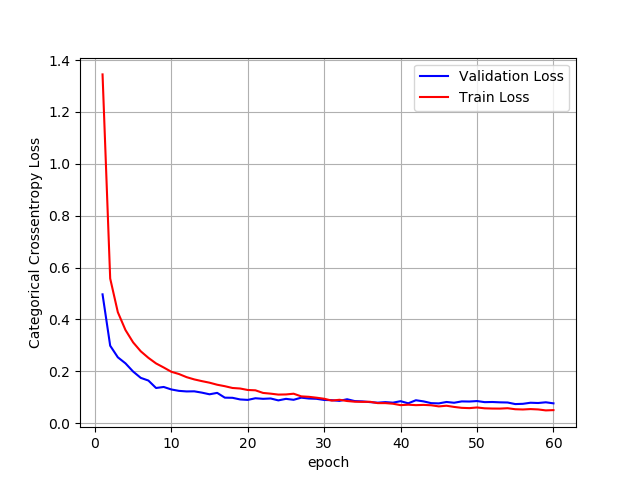

In [60]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Let's give a look at the weights which lead to this accuracy of our model.

<IPython.core.display.Javascript object>


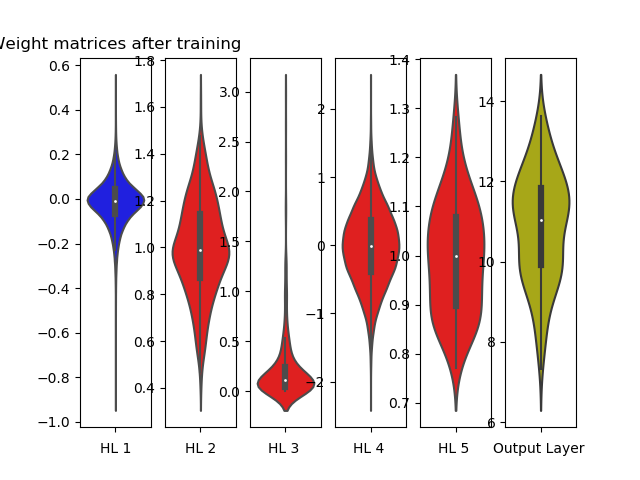

In [61]:
w_after = model_final.get_weights()

h1_w = w_after[0].flatten().reshape(-1,1)
h2_w = w_after[2].flatten().reshape(-1,1)
h3_w = w_after[4].flatten().reshape(-1,1)
h4_w = w_after[6].flatten().reshape(-1,1)
h5_w = w_after[8].flatten().reshape(-1,1)
out_w = w_after[10].flatten().reshape(-1,1)


fig = plt.figure()

plt.subplot(1, 6, 1)
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('HL 1')

plt.title("Weight matrices after training")
plt.subplot(1, 6, 2)
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('HL 2')

plt.subplot(1, 6, 3)
ax = sns.violinplot(y=h3_w, color='r')
plt.xlabel('HL 3 ')

plt.subplot(1, 6, 4)
ax = sns.violinplot(y=h4_w, color='r')
plt.xlabel('HL 4 ')

plt.subplot(1, 6, 5)
ax = sns.violinplot(y=h5_w, color='r')
plt.xlabel('HL 5 ')

plt.subplot(1, 6, 6)
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')

plt.show()

## Now Randomly trying different MLP architectures with different configurations.

### RELU ACTIVATION + ADAM OPTIMIZER + Model Architecture -->  [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2 (128 neurons))---(hidden layer 3 (256 neurons))--(hidden layer 4 (1024 neurons))----(hidden layer 5 (2048 neurons))---(output layer)] 

In [62]:
model_final = Sequential()

model_final.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))


model_final.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )


model_final.add(Dense(256, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )


model_final.add(Dense(1024, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )


model_final.add(Dense(2048, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )


model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_22 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_25 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_26 (Dense)             (None, 10)                20490     
Total params: 2,883,466
Trainable params: 2,883,466
Non-trainable params: 0
_________________________________________________________________


In [63]:
nb_epoch = 40

In [64]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 44us/step - loss: 14.5342 - acc: 0.0983 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 2/40
60000/60000 [==============================] - 2s 27us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 3/40
60000/60000 [==============================] - 2s 28us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 4/40
60000/60000 [==============================] - 2s 29us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 5/40
60000/60000 [==============================] - 2s 29us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 6/40
60000/60000 [==============================] - 2s 29us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.5740 - val_acc: 0.0958
Epoch 7/40
60000/60000 [==============================] - 2s 29us/step - loss: 14.5283 - acc: 0.0986 - val_loss: 14.

Test score: 14.573981648254394
Test accuracy: 0.0958


<IPython.core.display.Javascript object>


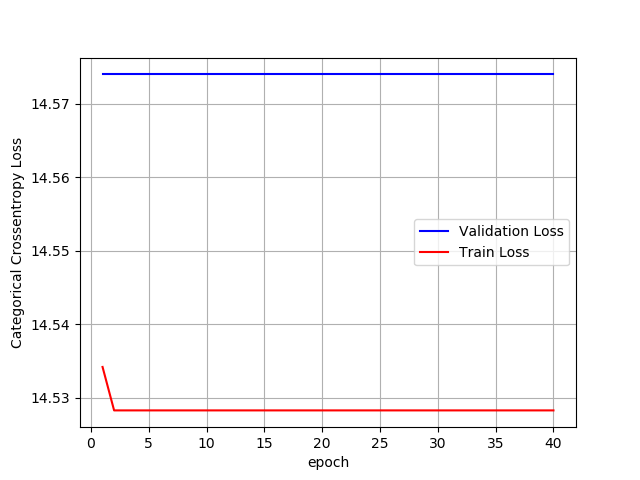

In [65]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### We can clearly see that as we removed the drop out layers and batch normalization we noticed a very poor accuracy for same number of epochs.

### RELU ACTIVATION + SGD OPTIMIZER + Batch Normalization + Model Architecture -->  [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2 (128 neurons))---(hidden layer 3 (256 neurons))--(hidden layer 4 (1024 neurons))----(hidden layer 5 (2048 neurons))---(output layer)] 

In [67]:
model_final = Sequential()

model_final.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_final.add(BatchNormalization())

model_final.add(Dense(128, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())

model_final.add(Dense(256, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())

model_final.add(Dense(1024, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())

model_final.add(Dense(2048, activation='relu', kernel_initializer=RandomNormal(mean=0.0, stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())

model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               401920    
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_29 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_30 (Dense)             (None, 256)               33024     
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              263168    
__________

In [68]:
nb_epoch = 40
batch_size = 128 

In [69]:
model_final.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 90us/step - loss: 0.4617 - acc: 0.8571 - val_loss: 0.2238 - val_acc: 0.9308
Epoch 2/40
60000/60000 [==============================] - 4s 68us/step - loss: 0.1828 - acc: 0.9455 - val_loss: 0.1717 - val_acc: 0.9482
Epoch 3/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.1333 - acc: 0.9603 - val_loss: 0.1496 - val_acc: 0.9549
Epoch 4/40
60000/60000 [==============================] - 4s 66us/step - loss: 0.1038 - acc: 0.9696 - val_loss: 0.1361 - val_acc: 0.9595
Epoch 5/40
60000/60000 [==============================] - 4s 67us/step - loss: 0.0853 - acc: 0.9755 - val_loss: 0.1279 - val_acc: 0.9608
Epoch 6/40
60000/60000 [==============================] - 4s 65us/step - loss: 0.0699 - acc: 0.9804 - val_loss: 0.1229 - val_acc: 0.9628
Epoch 7/40
60000/60000 [==============================] - 4s 65us/step - loss: 0.0603 - acc: 0.9825 - val_loss: 0.1178 - val_acc

Test score: 0.10197011248232156
Test accuracy: 0.9729


<IPython.core.display.Javascript object>


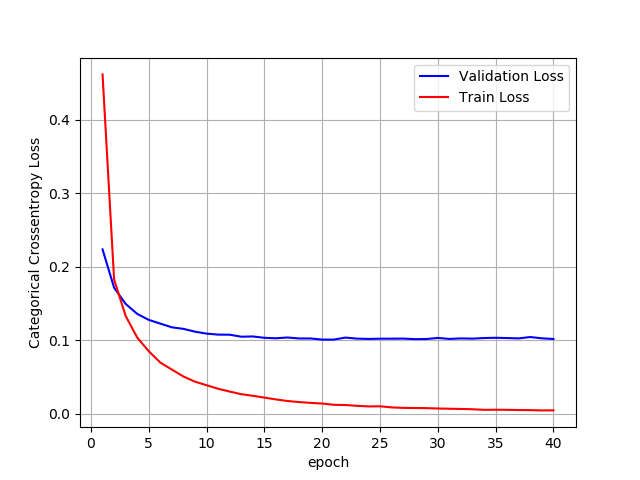

In [70]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Sigmoid activation +adam optimizer+ Dropout(with rate = 0.75) +  Model Architecture --> [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2(128 neurons))---(hidden layer 3 (256 neurons))---(output layer)]

In [34]:
model_final = Sequential()
model_final.add(Dense(512, activation='sigmoid', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_final.add(Dropout(0.75))

model_final.add(Dense(128, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0,stddev=0.55, seed=None)) )
model_final.add(Dropout(0.75))

model_final.add(Dense(256, activation='sigmoid', kernel_initializer=RandomNormal(mean=0.0,stddev=0.55, seed=None)) )
model_final.add(Dropout(0.75))

model_final.add(Dense(output_dim, activation='softmax'))
model_final.summary()

W1002 10:26:23.843827  9664 deprecation_wrapper.py:119] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1002 10:26:23.882996  9664 deprecation_wrapper.py:119] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 10:26:23.893732  9664 deprecation_wrapper.py:119] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1002 10:26:23.910495  9664 deprecation_wrapper.py:119] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1002 10:26:23.916351  9

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total para

In [35]:
nb_epoch = 40

In [36]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_final.fit(X_train, Y_train, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

W1002 10:28:01.442343  9664 deprecation_wrapper.py:119] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1002 10:28:01.545196  9664 deprecation.py:323] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 8s 128us/step - loss: 2.4287 - acc: 0.1483 - val_loss: 1.4073 - val_acc: 0.5483
Epoch 2/40
60000/60000 [==============================] - 6s 99us/step - loss: 1.5549 - acc: 0.4082 - val_loss: 0.8020 - val_acc: 0.7208
Epoch 3/40
60000/60000 [==============================] - 6s 99us/step - loss: 1.1108 - acc: 0.5945 - val_loss: 0.5479 - val_acc: 0.8673
Epoch 4/40
60000/60000 [==============================] - 6s 101us/step - loss: 0.8947 - acc: 0.6925 - val_loss: 0.4284 - val_acc: 0.8903
Epoch 5/40
60000/60000 [==============================] - 6s 99us/step - loss: 0.7512 - acc: 0.7584 - val_loss: 0.3424 - val_acc: 0.9213
Epoch 6/40
60000/60000 [==============================] - 6s 100us/step - loss: 0.6529 - acc: 0.8037 - val_loss: 0.2887 - val_acc: 0.9314
Epoch 7/40
60000/60000 [==============================] - 6s 99us/step - loss: 0.5830 - acc: 0.8317 - val_loss: 0.2646 - val_

Test score: 0.12213036285452544
Test accuracy: 0.9721


<IPython.core.display.Javascript object>


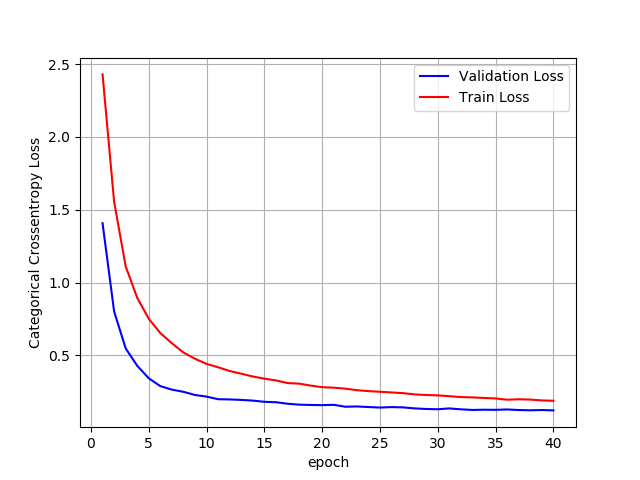

In [38]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Tanh activation +adam optimizer+ Batch Normalization +  Model Architecture --> [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2(128 neurons))---(hidden layer 3 (256 neurons))---(output layer)]

In [26]:
model_final = Sequential()
model_final.add(Dense(512, activation='tanh', input_shape=(input_dim,), kernel_initializer=RandomNormal(mean=0.0, stddev=0.039, seed=None)))
model_final.add(BatchNormalization())

model_final.add(Dense(128, activation='tanh', kernel_initializer=RandomNormal(mean=0.0,
stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())

model_final.add(Dense(256, activation='tanh', kernel_initializer=RandomNormal(mean=0.0,
stddev=0.55, seed=None)) )
model_final.add(BatchNormalization())

model_final.add(Dense(output_dim, activation='softmax'))
model_final.summary()

W1003 04:23:29.100877 14324 deprecation_wrapper.py:119] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
Total para

In [27]:
nb_epoch = 30
batch_size = 64

In [28]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_final.fit(X_train, Y_train, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

W1003 04:23:33.710057 14324 deprecation.py:323] From C:\Users\RASHU TYAGI\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 13s 216us/step - loss: 0.4363 - acc: 0.8650 - val_loss: 0.2711 - val_acc: 0.9171
Epoch 2/30
60000/60000 [==============================] - 11s 182us/step - loss: 0.2792 - acc: 0.9136 - val_loss: 0.2183 - val_acc: 0.9335
Epoch 3/30
60000/60000 [==============================] - 11s 183us/step - loss: 0.2351 - acc: 0.9277 - val_loss: 0.1845 - val_acc: 0.9446
Epoch 4/30
60000/60000 [==============================] - 11s 181us/step - loss: 0.2073 - acc: 0.9361 - val_loss: 0.1667 - val_acc: 0.9490
Epoch 5/30
60000/60000 [==============================] - 11s 181us/step - loss: 0.1865 - acc: 0.9439 - val_loss: 0.1544 - val_acc: 0.9537
Epoch 6/30
60000/60000 [==============================] - 11s 181us/step - loss: 0.1682 - acc: 0.9478 - val_loss: 0.1342 - val_acc: 0.9585
Epoch 7/30
60000/60000 [==============================] - 11s 182us/step - loss: 0.1584 - acc: 0.9523 - val_loss: 0.

Test score: 0.08960605073939078
Test accuracy: 0.9736


<IPython.core.display.Javascript object>


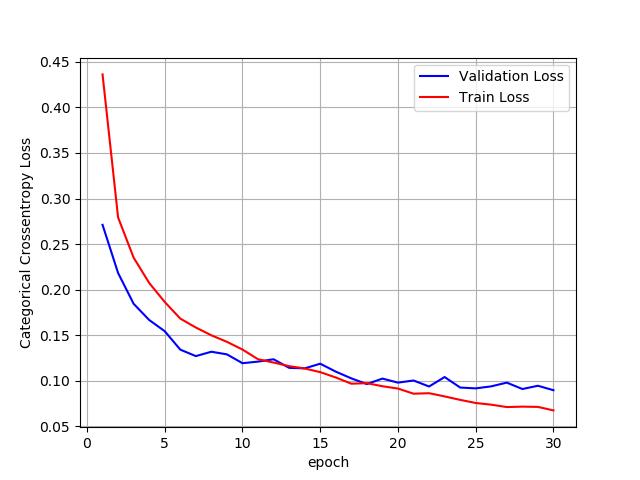

In [29]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Next architecture

### glorot_uniform initialization + sgd optimizer + relu activation function + Dropout(0.33) + no batch normalization +  Model Architecture -->  [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2 (128 neurons))---(hidden layer 3 (256 neurons))--(hidden layer 4 (1024 neurons))----(hidden layer 5 (2048 neurons))---(output layer)]

In [36]:

import keras.utils

model_final = Sequential()

model_final.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer = keras.initializers.glorot_normal(seed=None)))
model_final.add(Dropout(0.33))

model_final.add(Dense(128, activation='relu', kernel_initializer = keras.initializers.glorot_normal(seed=None)))
model_final.add(Dropout(0.33))

model_final.add(Dense(256, activation='relu', kernel_initializer = keras.initializers.glorot_normal(seed=None)))
model_final.add(Dropout(0.33))

model_final.add(Dense(1024, activation='relu', kernel_initializer = keras.initializers.glorot_normal(seed=None)))
model_final.add(Dropout(0.33))

model_final.add(Dense(2048, activation='relu', kernel_initializer = keras.initializers.glorot_normal(seed=None)))
model_final.add(Dropout(0.33))

model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              263168    
__________

In [37]:
nb_epoch = 60

In [38]:
model_final.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 4s 68us/step - loss: 1.8581 - acc: 0.3439 - val_loss: 0.7089 - val_acc: 0.7973
Epoch 2/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.7309 - acc: 0.7606 - val_loss: 0.3608 - val_acc: 0.8915
Epoch 3/60
60000/60000 [==============================] - 4s 60us/step - loss: 0.4883 - acc: 0.8503 - val_loss: 0.2734 - val_acc: 0.9179
Epoch 4/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.3872 - acc: 0.8858 - val_loss: 0.2224 - val_acc: 0.9335
Epoch 5/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.3271 - acc: 0.9028 - val_loss: 0.1916 - val_acc: 0.9418
Epoch 6/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.2824 - acc: 0.9163 - val_loss: 0.1719 - val_acc: 0.9490
Epoch 7/60
60000/60000 [==============================] - 3s 58us/step - loss: 0.2523 - acc: 0.9250 - val_loss: 0.1520 - val_acc

60000/60000 [==============================] - 3s 58us/step - loss: 0.0341 - acc: 0.9892 - val_loss: 0.0759 - val_acc: 0.9832


Test score: 0.07590167486594146
Test accuracy: 0.9832


<IPython.core.display.Javascript object>


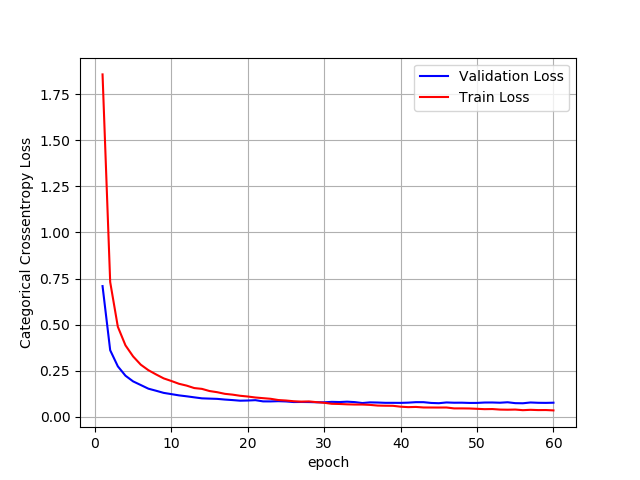

In [39]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

## Next Architecture

## he_normal initialization + adam optimizer + softmax activation function + Dropout(0.66) + batch normalization(to only 2 layers) + Model Architecture --> [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2 (128 neurons))---(hidden layer 3 (256 neurons))--(hidden layer 4 (1024 neurons))----(hidden layer 5 (2048 neurons))---(output layer)]

In [40]:
# refer this for he_normal initialization --> https://keras.io/activations/
import keras.utils

model_final = Sequential()

model_final.add(Dense(512, activation='softmax', input_shape=(input_dim,), kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))


model_final.add(Dense(128, activation='softmax', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))
model_final.add(BatchNormalization())

model_final.add(Dense(256, activation='softmax', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))


model_final.add(Dense(1024, activation='softmax', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))


model_final.add(Dense(2048, activation='softmax', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))
model_final.add(BatchNormalization())

model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

W1003 06:40:12.831539 14324 nn_ops.py:4224] Large dropout rate: 0.66 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1003 06:40:12.853988 14324 nn_ops.py:4224] Large dropout rate: 0.66 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1003 06:40:12.924259 14324 nn_ops.py:4224] Large dropout rate: 0.66 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1003 06:40:12.944783 14324 nn_ops.py:4224] Large dropout rate: 0.66 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1003 06:40:12.964304 14324 nn_ops.py:4224] Large dropout rate: 0.66 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_16 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
__________

In [42]:
nb_epoch = 50
batch_size = 256


In [43]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 56us/step - loss: 2.3027 - acc: 0.1090 - val_loss: 2.3015 - val_acc: 0.1028
Epoch 2/50
60000/60000 [==============================] - 2s 38us/step - loss: 2.3031 - acc: 0.1086 - val_loss: 2.3016 - val_acc: 0.1135
Epoch 3/50
60000/60000 [==============================] - 2s 38us/step - loss: 2.3031 - acc: 0.1083 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 4/50
60000/60000 [==============================] - 2s 37us/step - loss: 2.3028 - acc: 0.1077 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 5/50
60000/60000 [==============================] - 2s 38us/step - loss: 2.3027 - acc: 0.1073 - val_loss: 2.3025 - val_acc: 0.1135
Epoch 6/50
60000/60000 [==============================] - 2s 37us/step - loss: 2.3028 - acc: 0.1098 - val_loss: 2.3018 - val_acc: 0.1028
Epoch 7/50
60000/60000 [==============================] - 2s 38us/step - loss: 2.3030 - acc: 0.1076 - val_loss: 2.3031 - val_acc

Test score: 2.3016698822021486
Test accuracy: 0.101


<IPython.core.display.Javascript object>


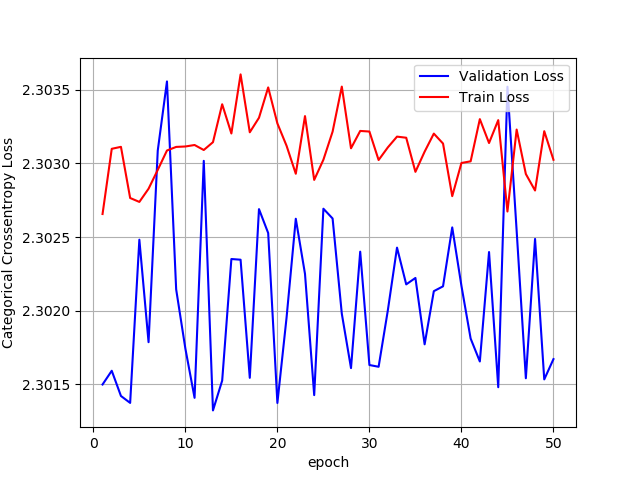

In [44]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### We received a very poor accuracy over there let us try the same code with relu activation 

In [46]:
# refer this for he_normal initialization --> https://keras.io/activations/
import keras.utils

model_final = Sequential()

model_final.add(Dense(512, activation='relu', input_shape=(input_dim,), kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))


model_final.add(Dense(128, activation='relu', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))
model_final.add(BatchNormalization())

model_final.add(Dense(256, activation='relu', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))


model_final.add(Dense(1024, activation='relu', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))


model_final.add(Dense(2048, activation='relu', kernel_initializer = keras.initializers.he_normal(seed=None)))
model_final.add(Dropout(0.66))
model_final.add(BatchNormalization())

model_final.add(Dense(output_dim, activation='softmax'))


model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_22 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
__________

In [47]:
nb_epoch = 50
batch_size = 256


In [48]:
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 1.9138 - acc: 0.3571 - val_loss: 1.3399 - val_acc: 0.4876
Epoch 2/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.9259 - acc: 0.6837 - val_loss: 0.5729 - val_acc: 0.7837
Epoch 3/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.6319 - acc: 0.8045 - val_loss: 0.4046 - val_acc: 0.8502
Epoch 4/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.5001 - acc: 0.8528 - val_loss: 0.2862 - val_acc: 0.9020
Epoch 5/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.4270 - acc: 0.8785 - val_loss: 0.2521 - val_acc: 0.9145
Epoch 6/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.3747 - acc: 0.8951 - val_loss: 0.1859 - val_acc: 0.9466
Epoch 7/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.3425 - acc: 0.9070 - val_loss: 0.1850 - val_acc

Test score: 0.08166552726062946
Test accuracy: 0.9802


<IPython.core.display.Javascript object>


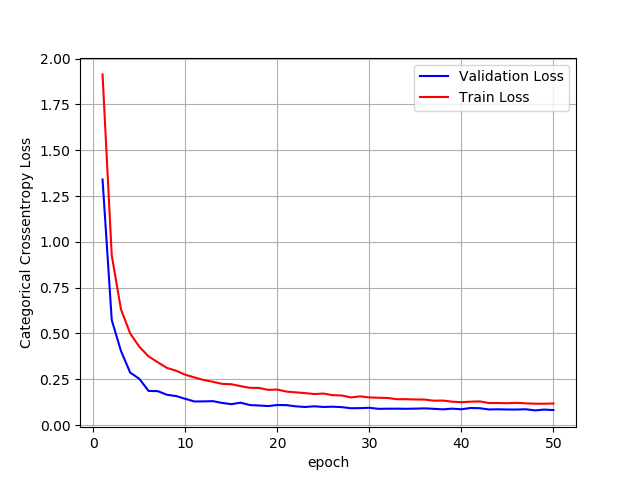

In [49]:
score = model_final.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [53]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()

x.field_names = ["Architecture used","Hidden layers","Activation", "Optimizer used", "epochs","Dropouts","BN(batch size)"," accuracy"]

x.add_row(["784-512-128-10", 2,"RELU","Adam" , 20,"yes","yes(128)",0.9825])
x.add_row(["784-512-128-256-10", 3,"RELU","Adam" , 40,"yes","yes(128)",0.9833])
x.add_row(["784-512-128-256-1024-2048-10", 5,"RELU","Adam" , 60,"yes","yes(256)",0.9841])
x.add_row(["784-512-128-256-1024-2048-10", 5,"RELU","Adam" , 40,"no","no",0.0958])
x.add_row(["784-512-128-256-1024-2048-10", 5,"RELU","SGD" , 40,"no","yes(128)",0.9729])
x.add_row(["784-512-128-256-10", 3,"sigmoid","Adam" , 40,"yes","no",0.9721])
x.add_row(["784-512-128-256-10", 3,"tanh","Adam" , 30,"no","yes(64)",0.9736])
x.add_row(["784-512-128-256-1024-2048-10", 5,"RELU","SGD" , 60,"yes","no",0.9832])
x.add_row(["784-512-128-256-1024-2048-10", 5,"softmax","Adam" , 50,"yes","yes(256)",0.101])
x.add_row(["784-512-128-256-1024-2048-10", 5,"relu","Adam" , 50,"yes","yes(256)",0.9802])


print(x)

+------------------------------+---------------+------------+----------------+--------+----------+----------------+-----------+
|      Architecture used       | Hidden layers | Activation | Optimizer used | epochs | Dropouts | BN(batch size) |  accuracy |
+------------------------------+---------------+------------+----------------+--------+----------+----------------+-----------+
|        784-512-128-10        |       2       |    RELU    |      Adam      |   20   |   yes    |    yes(128)    |   0.9825  |
|      784-512-128-256-10      |       3       |    RELU    |      Adam      |   40   |   yes    |    yes(128)    |   0.9833  |
| 784-512-128-256-1024-2048-10 |       5       |    RELU    |      Adam      |   60   |   yes    |    yes(256)    |   0.9841  |
| 784-512-128-256-1024-2048-10 |       5       |    RELU    |      Adam      |   40   |    no    |       no       |   0.0958  |
| 784-512-128-256-1024-2048-10 |       5       |    RELU    |      SGD       |   40   |    no    |    ye

# Summary :-

## 1.) We tried various types of architectures for MLP with 2 hidden layers,3 hidden layers and 5 hidden layers also.

## 2.) We measured the accuracy for all the cases we considered

## 3.) Along with different architectures we tried different initializations like xavier/cohort initialization,he_normal initialization etc and varied them with applying batch normalization and sometimes removing batch normalizations.

## 4.) We also did experiments with dropout layers and we also changed the dropout rates as well.

## 5.) We also did experiments with the optimizers which are avaliable to us like adam,sgd etc.

## 6.) Final conclusion that can be said is that choosing which will be the right architecture for us and choosing the best initialization,dropout rates,epochs,optimizers actually depends on data also and also the initialized parameters also we can see in the above experiments that some architectures gave us a very good accuracy at very low epoch aslo while some couldn't give us a good accuracy even at high epoch numbers hence it can be said that only increasing the epochs does not gurantee us a good accuracy afterall.

## 7.) the graphs between the number of epochs and train/validation accuracy shows us how our model converges the loss to a value which is as minimum as possible in that epoch range.

## Best results - If we go with kaggle results methodilogy which is highly dependent upon the validation accuracy considering about all our experiments although some have very close accuracy still the best accuracy was found to be 98.32% for the following configuration :- 

# glorot_uniform initialization + sgd optimizer + relu activation function + Dropout(0.33) + no batch normalization + Model Architecture --> [(input)--(hidden layer 1 (512 neurons))--(hidden layer 2 (128 neurons))---(hidden layer 3 (256 neurons))--(hidden layer 4 (1024 neurons))----(hidden layer 5 (2048 neurons))---(output layer)]